# 예측값에 대하여...
지금 데이터는 class 불균형이 심하다.  
이러면 예측할 때도 불균형하게 class를 줄텐데...  
모집단이 그렇다면 맞는 방법이겠지만,  
특정 class가 과하게 몰려있는 경우도 이게 올바른 방법일까??

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import warnings

RANDOM_STATE = 42
np.seed = 42
DATA_PATH = "../data_0115/"

warnings.filterwarnings(action='ignore')
PATH_2017 = DATA_PATH + "train/KNOW_2017.csv"
PATH_2018 = DATA_PATH + "train/KNOW_2018.csv"
PATH_2019 = DATA_PATH + "train/KNOW_2019.csv"
PATH_2020 = DATA_PATH + "train/KNOW_2020.csv"

paths = [PATH_2017, PATH_2018, PATH_2019, PATH_2020]

know_train = [pd.read_csv(path) for path in paths]

TEST_PATH_2017 = DATA_PATH + "test/KNOW_2017_test.csv"
TEST_PATH_2018 = DATA_PATH + "test/KNOW_2018_test.csv"
TEST_PATH_2019 = DATA_PATH + "test/KNOW_2019_test.csv"
TEST_PATH_2020 = DATA_PATH + "test/KNOW_2020_test.csv"

TEST_PATHs = [TEST_PATH_2017, TEST_PATH_2018, TEST_PATH_2019, TEST_PATH_2020]

know_test = [pd.read_csv(path) for path in TEST_PATHs]

In [2]:
from sklearn.preprocessing import LabelEncoder
years = ['2017', '2018', '2019', '2020']

year_encoder = {}

for year, df in zip(years, know_train):
    print(year)
    encoders = {}
    
    for col in df.columns:
        if col == 'idx':
            print("HEHE")
            continue
        
        try:
            df[col] = df[col].map(int)
        except:
            encoder = LabelEncoder()
            df[col] = df[col].map(str)
            df[col] = encoder.fit_transform(df[col])
            encoders[col] = encoder
            
            
    year_encoder[year] = encoders

2017
HEHE
2018
HEHE
2019
HEHE
2020
HEHE


In [3]:
# preprocess test data
years = ['2017', '2018', '2019', '2020']

for year, df in zip(years, know_test):
    print(year)
    encoders = {}
    
    for col in df.columns:
        
        try:
            df[col] = df[col].map(int)
        except:
            encoder = year_encoder[year][col]
            df[col] = df[col].map(str)
            category_map = {category: idx for idx, category in enumerate(encoder.classes_)}
            df[col] = df[col].apply(lambda x: category_map[x] if x in category_map else -1) # train set에서 보지못한 카테고리변수 -1(UNK) 처리

2017
2018
2019
2020


In [4]:
train_data = {}
for year, df in zip(years, know_train):
    train_data[year] = {'X': df.drop(['idx','knowcode','description'], axis=1),
                        'y': df['knowcode']} 

In [5]:
test_data = {}
for year, df in zip(years, know_test):
    print(year)
    train_columns = train_data[year]['X'].columns
    # print(train_columns)
    test_data[year] =  {'X': df[train_columns]}

2017
2018
2019
2020


# SMOTE - data resampling

In [6]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [7]:
# resampling with SMOTE
train_data_resampled = {}

sample_num_per_year = {
    '2017': 50, 
    '2018': 30,
    '2019': 30,
    '2020': 18
}

for year in years:
    print(f"{year} sampling")
    target_counts = train_data[year]['y'].value_counts()
    resample_dict = {}
    sample_num = sample_num_per_year[year]
    k_neighbors = 6
    for i, num in target_counts.items():
        resample_dict[i] = max(num, sample_num)
        if num < k_neighbors:
            k_neighbors = num-1
            print(f"minimum neighbor size {k_neighbors}")

    smote = SMOTE(sampling_strategy=resample_dict, random_state=RANDOM_STATE,
            k_neighbors=k_neighbors
        )
    X_resampled, y_resampled = smote.fit_resample(train_data[year]['X'], train_data[year]['y'])
    
    train_data_resampled[year] = {
        'X': X_resampled, 'y': y_resampled
    }
    print("done")

2017 sampling
done
2018 sampling
done
2019 sampling
minimum neighbor size 3
done
2020 sampling
done


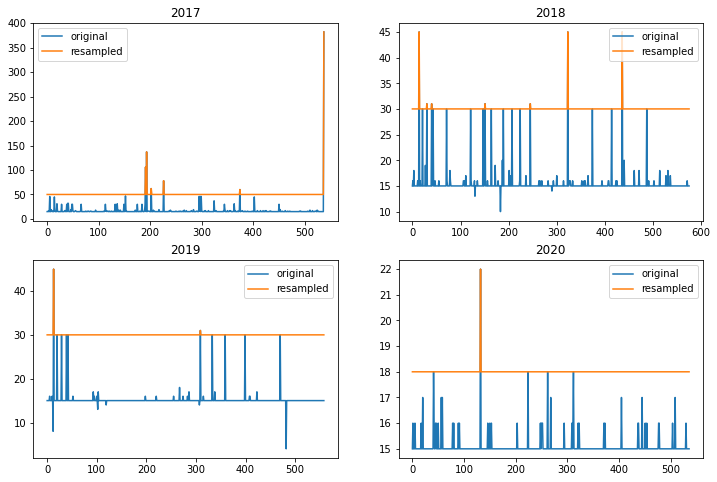

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year in years:
    if year == '2017': r,c = 0,0
    elif year == '2018': r,c = 0,1
    elif year == '2019': r,c = 1,0
    elif year == '2020': r,c = 1,1
    
    d1 = train_data[year]['y'].value_counts().sort_index().tolist()
    d2 = train_data_resampled[year]['y'].value_counts().sort_index().tolist()
    axes[r, c].plot(d1, label="original")
    axes[r, c].plot(d2, label="resampled")
    axes[r, c].set_title(year)
    axes[r, c].legend()

fig.show()

# Predict
* compare predicted data: 
    1. original vs resampled
    2. `n_estimators=100` vs `n_estimators=300`

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
et_models = {}

# original
print("train original data")
for year in tqdm(years):
    model = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=8)
    model.fit(train_data[year]['X'].iloc[:, :], train_data[year]['y'])
    et_models[year] = model
print("predict with original data")
et_predicts = {} 
for year in tqdm(years):
    pred = et_models[year].predict(test_data[year]['X'])
    et_predicts[year] = pred

# original_300
print("train original data n_estimators=300")
for year in tqdm(years):
    model = ExtraTreesClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=8)
    model.fit(train_data[year]['X'].iloc[:, :], train_data[year]['y'])
    et_models[year] = model
print("predict with original data n_estimators=300")
et_predicts_300 = {} 
for year in tqdm(years):
    pred = et_models[year].predict(test_data[year]['X'])
    et_predicts_300[year] = pred

# resampled
print("train resampled data")
for year in tqdm(years):
    model = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=8)
    model.fit(train_data_resampled[year]['X'].iloc[:, :], train_data_resampled[year]['y'])
    et_models[year] = model
print("predict with resampled data")
et_predicts_resampled = {}
for year in tqdm(years):
    pred = et_models[year].predict(test_data[year]['X'])
    et_predicts_resampled[year] = pred

# resampled_300
# print("train resampled data n_estimators=300")
# for year in tqdm(years):
#     model = ExtraTreesClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=8)
#     model.fit(train_data_resampled[year]['X'].iloc[:, :], train_data_resampled[year]['y'])
#     et_models[year] = model
# print("predict with resampled data n_estimators=300")
# et_predicts_resampled = {}
# for year in tqdm(years):
#     pred = et_models[year].predict(test_data[year]['X'])
#     et_predicts_resampled_300[year] = pred

train original data


100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


predict with original data


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


train original data n_estimators=300


100%|██████████| 4/4 [00:31<00:00,  7.90s/it]


predict with original data n_estimators=300


100%|██████████| 4/4 [00:15<00:00,  3.86s/it]


train resampled data


100%|██████████| 4/4 [00:18<00:00,  4.52s/it]


predict with resampled data


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


In [10]:
original_predicted_counters = {}
original_predicted_counters_300 = {}
resampled_predicted_counters = {}
# resampled_predicted_counters_300 = {}
for year in years:
    original_predicted_counters[year] = {}
    original_predicted_counters_300[year] = {}
    resampled_predicted_counters[year] = {}
    # resampled_predicted_counters_300[year] = {}
    for pred in et_predicts[year]:
        if pred not in original_predicted_counters[year].keys():
            original_predicted_counters[year][pred] = 1
        else: 
            original_predicted_counters[year][pred] += 1
    for pred in et_predicts_300[year]:
        if pred not in original_predicted_counters_300[year].keys():
            original_predicted_counters_300[year][pred] = 1
        else: 
            original_predicted_counters_300[year][pred] += 1
    for pred in et_predicts_resampled[year]:
        if pred not in resampled_predicted_counters[year].keys():
            resampled_predicted_counters[year][pred] = 1
        else: 
            resampled_predicted_counters[year][pred] += 1
    # for pred in et_predicts_resampled_300[year]:
    #     if pred not in resampled_predicted_counters_300[year].keys():
    #         resampled_predicted_counters_300[year][pred] = 1
    #     else: 
    #         resampled_predicted_counters_300[year][pred] += 1

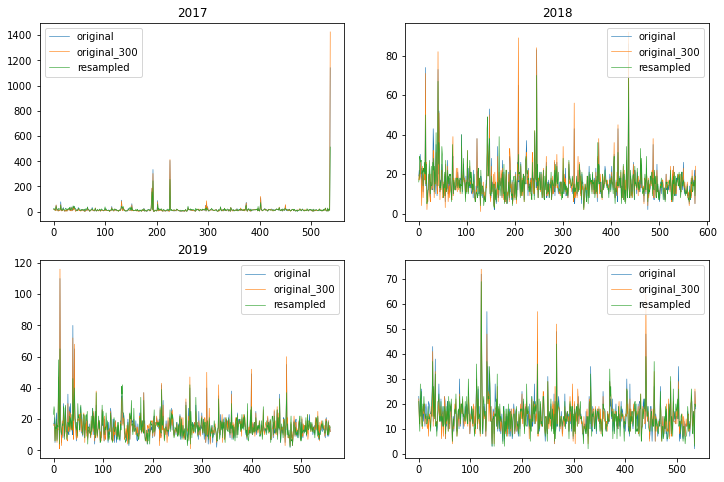

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year in years:
    if year == '2017': r,c = 0,0
    elif year == '2018': r,c = 0,1
    elif year == '2019': r,c = 1,0
    elif year == '2020': r,c = 1,1
    
    l1 = sorted(original_predicted_counters[year].items(), key=lambda x: x[0])
    d1 = [x[1] for x in l1]
    l1_300 = sorted(original_predicted_counters_300[year].items(), key=lambda x: x[0])
    d1_300 = [x[1] for x in l1_300]
    l2 = sorted(resampled_predicted_counters[year].items(), key=lambda x: x[0])
    d2 = [x[1] for x in l2]
    # l2_300 = sorted(resampled_predicted_counters_300[year].items(), key=lambda x: x[0])
    # d2_300 = [x[1] for x in l2_300]
    axes[r, c].plot(d1, label="original", linewidth=0.6)
    axes[r, c].plot(d1_300, label="original_300", linewidth=0.6)
    axes[r, c].plot(d2, label="resampled", linewidth=0.6)
    # axes[r, c].plot(d2_300, label="resampled_300", linewidth=0.6)
    axes[r, c].legend()
    axes[r, c].set_title(year)

fig.show()

In [12]:
# calculate variance

for year in years:
    print(year)

    l1 = sorted(original_predicted_counters[year].items(), key=lambda x: x[0])
    d1 = [x[1] for x in l1]
    print(f"original      std: {np.std(d1):3.4}")

    l1_300 = sorted(original_predicted_counters_300[year].items(), key=lambda x: x[0])
    d1_300 = [x[1] for x in l1_300]
    print(f"original_300  std: {np.std(d1_300):3.4}")

    l2 = sorted(resampled_predicted_counters[year].items(), key=lambda x: x[0])
    d2 = [x[1] for x in l2]
    print(f"resampled     std: {np.std(d2):3.4}")

    # l2_300 = sorted(resampled_predicted_counters_300[year].items(), key=lambda x: x[0])
    # d2_300 = [x[1] for x in l2_300]
    # print(f"resampled std: {np.std(d2_300):3.4}")

2017
original      std: 54.79
original_300  std: 65.71
resampled     std: 27.76
2018
original      std: 8.79
original_300  std: 9.366
resampled     std: 7.721
2019
original      std: 8.389
original_300  std: 8.607
resampled     std: 7.064
2020
original      std: 6.787
original_300  std: 6.633
resampled     std: 6.523


* 확실히 resample 된 데이터가 좀 더 고르게 예측
* 2017년에서 예측값이 과하게 99999에 몰려있어서 이것만 좀 해결해도 성능이 오를 수 있지 않을까??
* knowcode 99999인 애들이 major 주로 뭐로 답변했는지 봐야할듯